In [1]:
%pylab inline
import pandas as pd
from collections import Counter
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [14]:
from nltk.corpus import stopwords
from nltk import word_tokenize
stop = set(stopwords.words('english'))

In [2]:
TRAIN_FILE = '../../data/train.csv'
TEST_FILE = '../../data/test.csv'

In [3]:
train = pd.read_csv(TRAIN_FILE)

In [4]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## Find character length of text

In [5]:
train['length'] = train['text'].str.len()

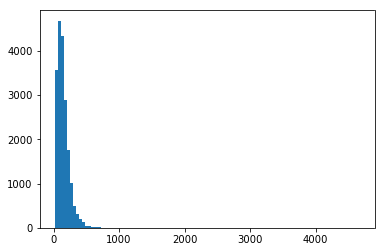

In [6]:
plt.hist(train['length'],bins=100);

## Find number of words in a sentence

In [7]:
train['words'] = train['text'].str.split().apply(len)

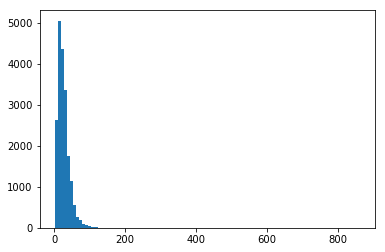

In [8]:
plt.hist(train['words'],bins=100);

What is the biggest passage length?

In [9]:
train['no. of words'].max()

861

## Find the most common words for each author

In [15]:
result = dict()

for author in train['author'].unique():
    c = Counter()
    df = train[train['author'] == author]
    df['text'].str.lower().str.split().apply(c.update)#.apply(lambda x: Counter(x.lower().split()))
    for sword in stop:
        del c[sword]
    result[author] = c

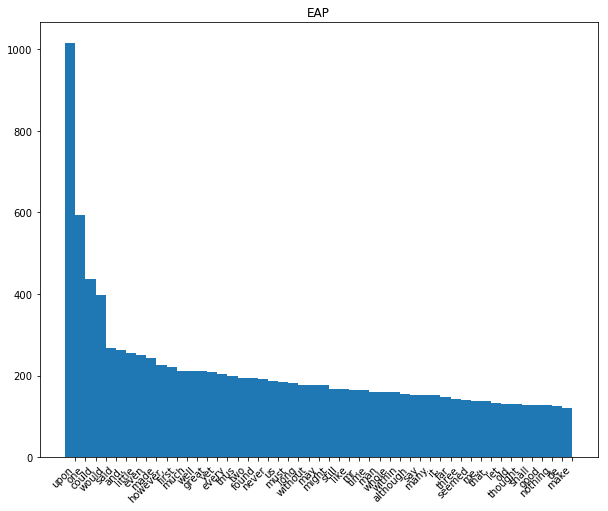

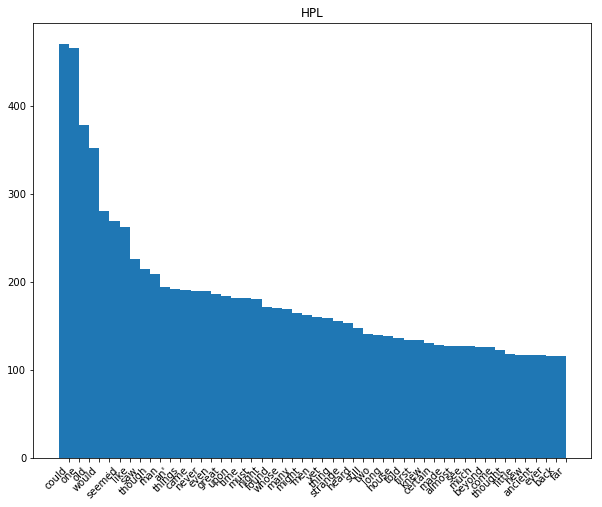

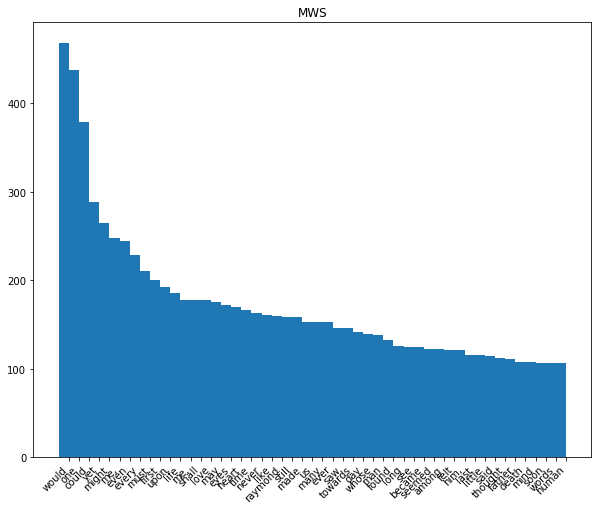

In [21]:
for author in train['author'].unique():
    labels, values = zip(*result[author].most_common(50))
    indexes = np.arange(len(labels))
    width = 1
    plt.figure(figsize=(10,8))
    plt.title(author)
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels,rotation=45,ha='right')

    plt.show()

## Find words unique to each author
* extract unique words for each author
* find words that aren't contained in other authors list
* print these words out (word cloud?)

In [85]:
result = dict()

for author in train['author'].unique():
    c = set()
    df = train[train['author'] == author]
    df['text'].str.lower().str.split().apply(c.update)#.apply(lambda x: Counter(x.lower().split()))
    result[author] = c

unique_words = dict()
for author in  train['author'].unique(): 
    c = result[author]
    other_authors = train['author'].unique()
    other_authors = other_authors[other_authors!=author]
    for a in other_authors:
        c = c - result[a]
    unique_words[author] = c

In [84]:
authors = train['author'].unique()
author = 'EAP'
authors[authors!=author]

array(['HPL', 'MWS'], dtype=object)

### Count differences in corpus between authors

In [87]:
for author in unique_words.keys():
    print('word unique to author {}: {}'.format(author,len(unique_words[author])))

word unique to author EAP: 12423
word unique to author HPL: 9827
word unique to author MWS: 7704


### Count for words that are unique to each author

To do this need to install `wordcloud` using the following command

```bash
conda install -c https://conda.anaconda.org/amueller wordcloud
```

In [91]:
counts = dict()

for author in train['author'].unique():
    c = Counter()
    df = train[train['author'] == author]
    df['text'].str.lower().str.split().apply(c.update)#.apply(lambda x: Counter(x.lower().split()))
    for sword in stop:
        del c[sword]
    u = unique_words[author]
    for word in list(c):
        if word not in u:
            del c[word]
    counts[author] = c

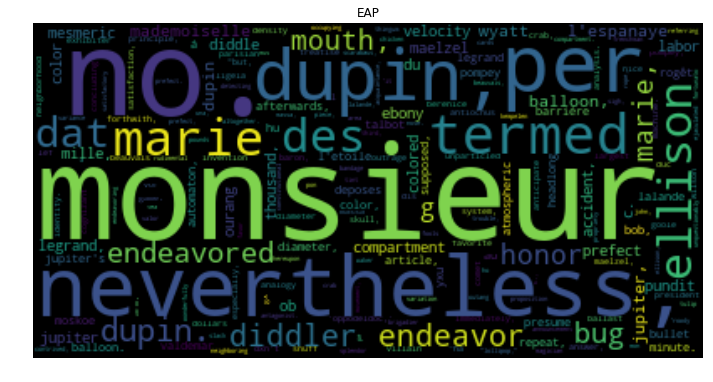

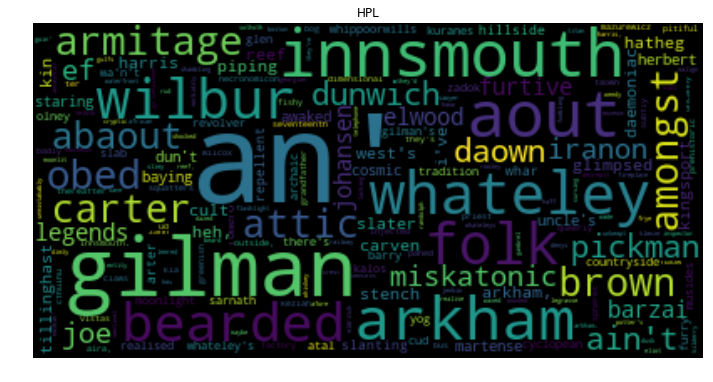

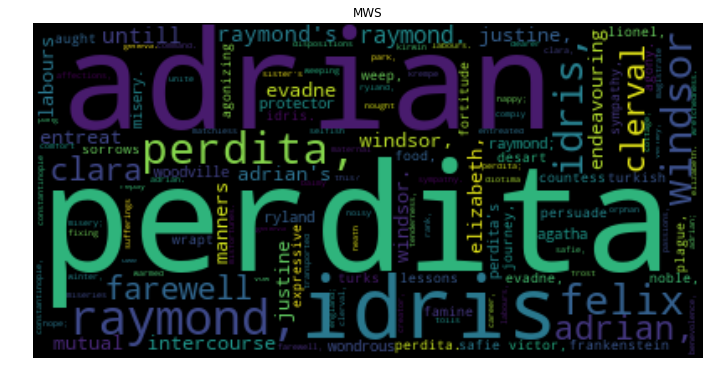

In [98]:
from wordcloud import WordCloud
for author in counts.keys():
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=counts[author])
    plt.figure(figsize=(12,10))
    plt.title(author)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Text frequency, inverse document frequency

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train['text'])
X_train_counts.shape

(19579, 25068)

In [26]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(19579, 25068)

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
clf = MultinomialNB().fit(X_train_tfidf, train['author'])

### train test split

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    train['text'], train['author'], test_size=0.33, random_state=42)

In [67]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('chi2', SelectKBest(chi2, k=10000)),
                     ('clf', MultinomialNB()),
])

In [68]:
text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...unction chi2 at 0x11725d0d0>)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [69]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test) 

0.79340761374187563